<a href="https://colab.research.google.com/github/MarcoFogale/PetitesAnnoncesTraining/blob/main/03_Models_Training_And_Selection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Capstone Project by Marco Fogale**

# **A Machine Learning Approach to Vehicle Price Prediction in Peer-to-Peer Used Car Sales**

# 03 - Models Training and Selection

**Objectives**
- Train different kind of regressor on the clean dataset and evaluate them on the same test dataset
  - Linear Models
  - Decision Tree Models
  - Support Vector Machines
  - Ensemble Methods
- Compare and comment all models performace
- Determine the best model to use for possible deployment

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os

import numpy as np
import pandas as pd

# ------- preliminary EDA data cleaning --------
import sys
sys.path.append('/content/drive/MyDrive/_CapstoneProject_')
import data_clean_preprocess as dcp
import plot_residuals as plt_res

# ------- Baseline evaluation dependecies --------
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold

from sklearn.linear_model import LinearRegression, Ridge, HuberRegressor, Lasso, ElasticNet, QuantileRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, BaggingRegressor, GradientBoostingRegressor, HistGradientBoostingRegressor, VotingRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR

from sklearn.model_selection import train_test_split
from sklearn.metrics import  r2_score,  mean_absolute_error

import matplotlib.pyplot as plt
import seaborn as sns

import joblib

SEED = 73
SCORING = 'neg_mean_absolute_error'
BASE_PATH = '/content/drive/MyDrive/_CapstoneProject_/'
RESULTS_FILE_PATH = '/content/drive/MyDrive/_CapstoneProject_/results_df.csv'

[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


In [ ]:
raw_df = pd.read_csv('/content/drive/MyDrive/_CapstoneProject_/petites_annonces_cars.csv', index_col=0)
features_dict, df = dcp.data_clean_preprocess(raw_df)

In [ ]:
X = df.drop(columns=['price'])
y = df['price']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=SEED
)

# **Linear Models**

## **Ridge Regressor**

As a first linear approach, we use the Ridge Regressor, which is a type of linear regression that adds an L2 penalty (the square of the coefficients) to the loss function.
This regularization shrinks large coefficients, improving stability and reducing overfitting.

>**Model Training**

In [ ]:
preprocessor = ColumnTransformer([
    ('numeric',  StandardScaler(), features_dict['numerical_features']),
    ('categorical', OneHotEncoder(handle_unknown='ignore'),
                   features_dict['categorical_features']),
    ('binary', 'passthrough', features_dict['binary_features']),
])

pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', Ridge())
])

param_grid = {
    'regressor__alpha': np.linspace(1, 5, 20)
}

cv = KFold(n_splits=5, shuffle=True, random_state=SEED)

ridge_grid = GridSearchCV(
    estimator=pipe,
    param_grid=param_grid,
    cv=cv,
    scoring=SCORING,
    n_jobs=-1,
    refit=True
)

ridge_grid.fit(X_train, y_train)
ridge_best_model = ridge_grid.best_estimator_
joblib.dump(ridge_best_model, os.path.join(BASE_PATH,"ridge.pkl"))

ridge_y_pred = ridge_best_model.predict(X_test)

>**Model Evaluation**

Ridge Regressor (in-depth analysis)
Best alpha: 1.21053
Test MAE (original scale): 4450.651379650666
Test R^2 (0.7763913655049891,)


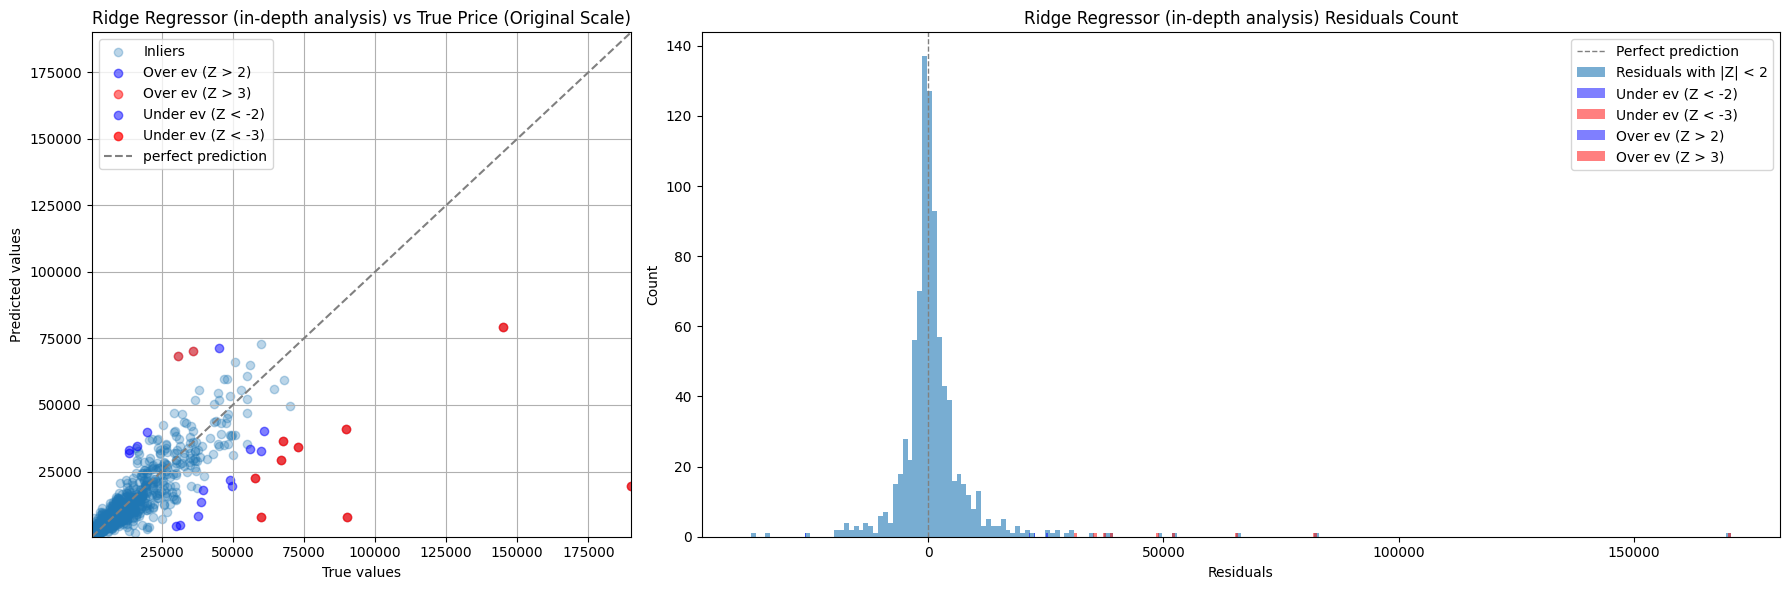

In [ ]:
model_name = 'Ridge Regressor (in-depth analysis)'
print(model_name)
print(f"Best alpha: {ridge_grid.best_params_['regressor__alpha']:.6g}")

ridge_r2 =  r2_score(y_test, ridge_y_pred),
ridge_mae = mean_absolute_error(10**y_test, 10**ridge_y_pred)
print("Test MAE (original scale):", ridge_mae)
print("Test R^2", ridge_r2)

plt_res.plot_residuals(y_test, ridge_y_pred, model_name)

results_df = pd.read_csv(RESULTS_FILE_PATH, index_col=[0])
if model_name in results_df.index:
  results_df = results_df.drop(model_name)

ridge_results_df = pd.DataFrame({'R^2': ridge_r2, 'MAE': ridge_mae}, index=[model_name])
results_df = pd.concat([results_df, ridge_results_df])

results_df.to_csv(RESULTS_FILE_PATH, mode='w')

>**Observation**

The Ridge Regressor outperforms the baseline model (MAE 4700), achieving a lower MAE of about 4451 and an R^2 of 0.776. This indicates both improved predictive accuracy and solid explanatory power, with moderate regularization (
alpha = 1.21) effectively balancing bias and variance.

## **Lasso Regressor**

Lasso Regressor, which is a type of linear regression that adds an L1 penalty (the absolute value of the coefficients) to the loss function.
This regularization drives some coefficients exactly to zero, performing feature selection while improving generalization.

In [ ]:
preprocessor = ColumnTransformer([
    ('numeric',  StandardScaler(), features_dict['numerical_features']),
    ('categorical', OneHotEncoder(handle_unknown='ignore'),
                   features_dict['categorical_features']),
    ('binary', 'passthrough', features_dict['binary_features']),
])

pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', Lasso(max_iter=10000, random_state=SEED))
])

param_grid = {
    'regressor__alpha': np.logspace(-4, 1, 30)
}

cv = KFold(n_splits=5, shuffle=True, random_state=SEED)

lasso_grid = GridSearchCV(
    estimator=pipe,
    param_grid=param_grid,
    cv=cv,
    scoring=SCORING,
    n_jobs=-1,
    refit=True
)

lasso_grid.fit(X_train, y_train)
lasso_best_model = lasso_grid.best_estimator_
joblib.dump(lasso_best_model, os.path.join(BASE_PATH,"lasso.pkl"))

lasso_y_pred = lasso_best_model.predict(X_test)

Lasso Regressor (in-depth analysis)
Best alpha: 0.0001
Test MAE (original scale): 4533.105473296839
Test R^2 0.768436417273523


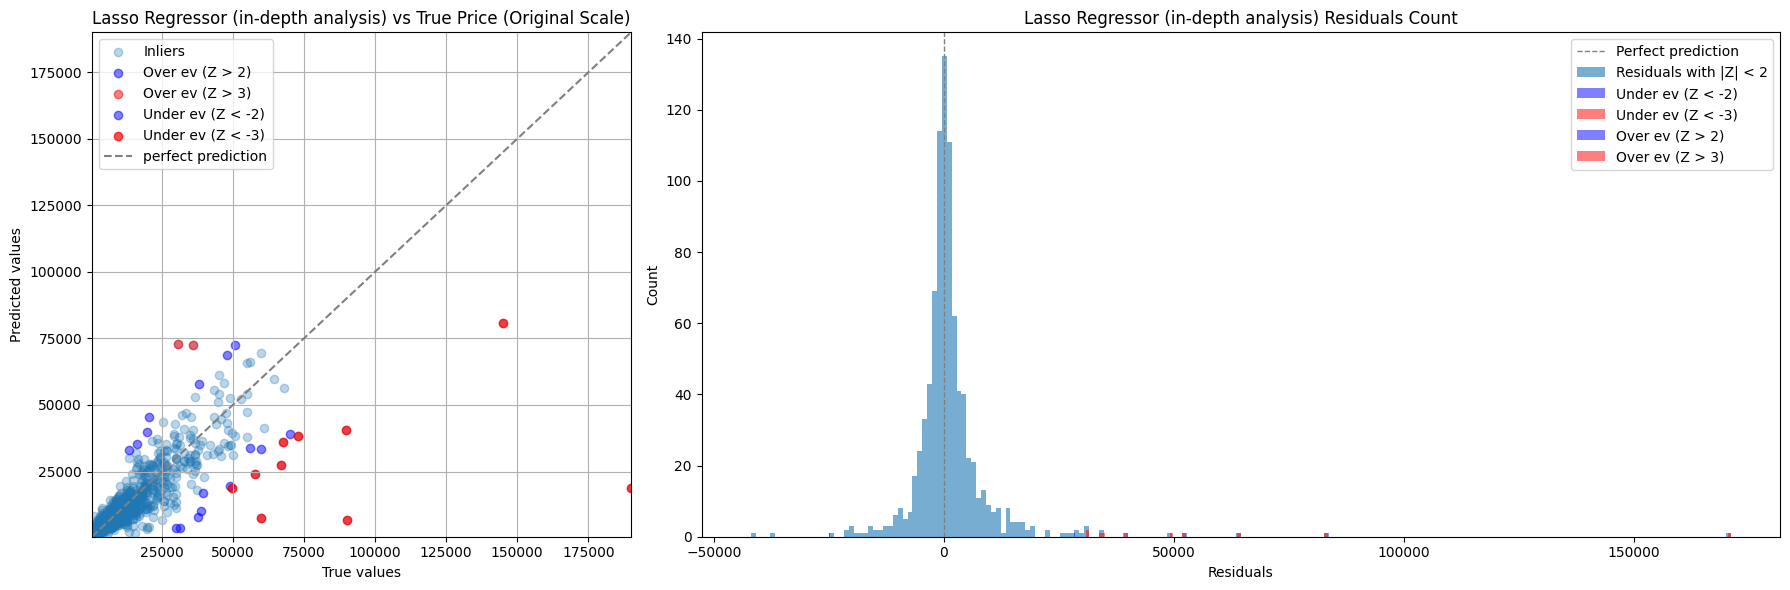

In [ ]:
model_name = 'Lasso Regressor (in-depth analysis)'
print(model_name)
print(f"Best alpha: {lasso_grid.best_params_['regressor__alpha']:.6g}")

lasso_r2 = r2_score(y_test, lasso_y_pred)
lasso_mae = mean_absolute_error(10**y_test, 10**lasso_y_pred)
print("Test MAE (original scale):", lasso_mae)
print("Test R^2", lasso_r2)

plt_res.plot_residuals(y_test, lasso_y_pred, model_name)

results_df = pd.read_csv(RESULTS_FILE_PATH, index_col=0)
if model_name in results_df.index:
    results_df = results_df.drop(model_name)

lasso_results_df = pd.DataFrame({'R^2': [lasso_r2], 'MAE': [lasso_mae]}, index=[model_name])
results_df = pd.concat([results_df, lasso_results_df])
results_df.to_csv(RESULTS_FILE_PATH, mode='w')

> **Observation**

The Lasso Regressor yields an MAE of about 4533 and an R^2 of 0.768, performing slightly worse than Ridge but still close to the baseline (MAE 4700). With a very small regularization parameter (alpha = 0.0001), it provides mild shrinkage while enabling feature selection.

## **Elastic-Net**

We also evaluate the ElasticNet Regressor, which combines the L1 penalty of Lasso with the L2 penalty of Ridge, aiming to balance feature selection with coefficient shrinkage.

In [ ]:
preprocessor = ColumnTransformer([
    ('numeric',  StandardScaler(), features_dict['numerical_features']),
    ('categorical', OneHotEncoder(handle_unknown='ignore'),
                   features_dict['categorical_features']),
    ('binary', 'passthrough', features_dict['binary_features']),
])

pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', ElasticNet(max_iter=10000, random_state=SEED))
])

param_grid = {
    'regressor__alpha': np.logspace(-4, 1, 30),
    'regressor__l1_ratio': [0.0001, 0.001, 0.01, 0.05, 0.1]
}

cv = KFold(n_splits=5, shuffle=True, random_state=SEED)

elastic_grid = GridSearchCV(
    estimator=pipe,
    param_grid=param_grid,
    cv=cv,
    scoring=SCORING,
    n_jobs=-1,
    refit=True
)

elastic_grid.fit(X_train, y_train)
elastic_best_model = elastic_grid.best_estimator_
joblib.dump(elastic_best_model, os.path.join(BASE_PATH, "elasticnet.pkl"))

elastic_y_pred = elastic_best_model.predict(X_test)

ElasticNet Regressor (in-depth analysis)
Best alpha: 0.00048939
Best l1_ratio: 0.01
Test MAE (original scale): 4458.5954055598
Test R^2 0.7756518370307566


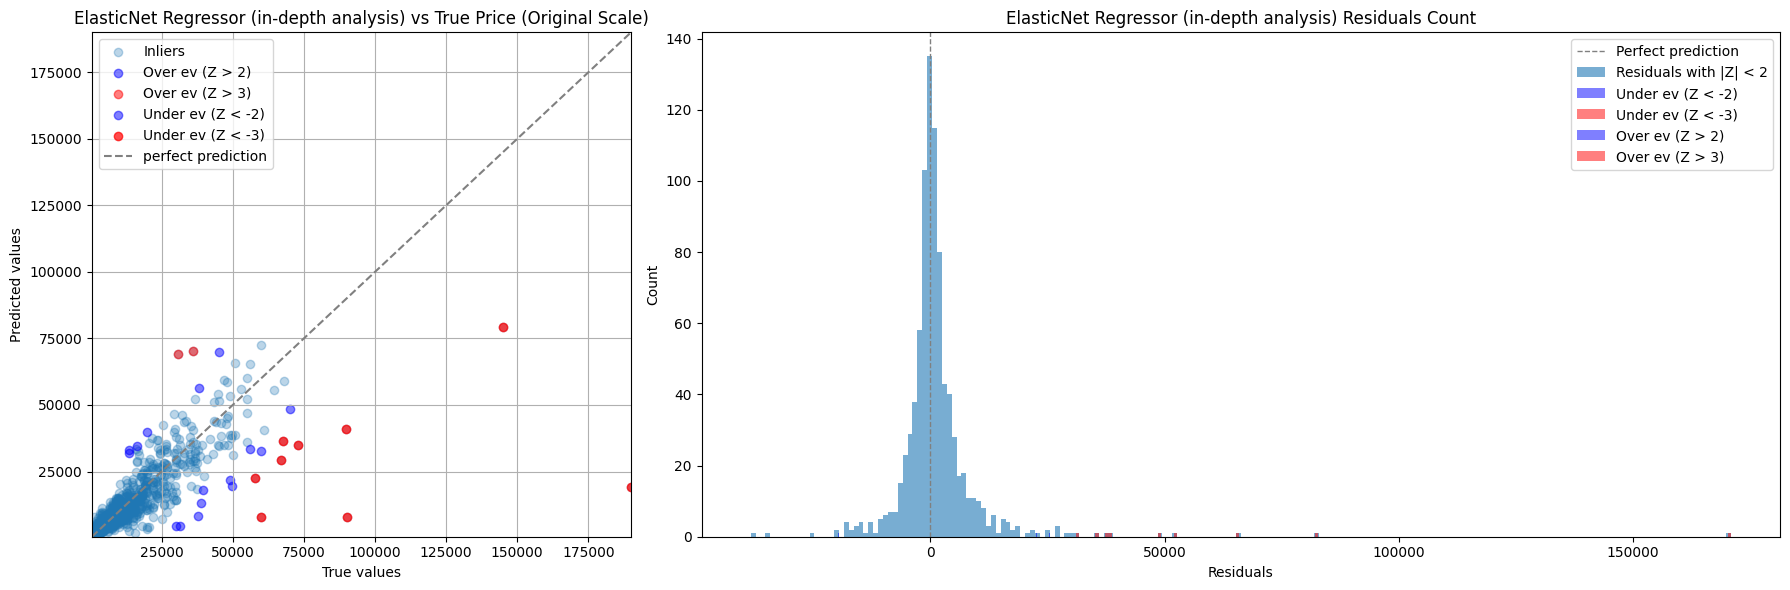

In [ ]:
model_name = 'ElasticNet Regressor (in-depth analysis)'
print(model_name)
print(f"Best alpha: {elastic_grid.best_params_['regressor__alpha']:.6g}")
print(f"Best l1_ratio: {elastic_grid.best_params_['regressor__l1_ratio']:.3g}")

elastic_r2 = r2_score(y_test, elastic_y_pred)
elastic_mae = mean_absolute_error(10**y_test, 10**elastic_y_pred)
print("Test MAE (original scale):", elastic_mae)
print("Test R^2", elastic_r2)

plt_res.plot_residuals(y_test, elastic_y_pred, model_name)

results_df = pd.read_csv(RESULTS_FILE_PATH, index_col=0)
if model_name in results_df.index:
    results_df = results_df.drop(model_name)

elastic_results_df = pd.DataFrame({'R^2': [elastic_r2], 'MAE': [elastic_mae]}, index=[model_name])
results_df = pd.concat([results_df, elastic_results_df])
results_df.to_csv(RESULTS_FILE_PATH, mode='w')

> **Observation**

The ElasticNet Regressor achieves an MAE of about 4459 and an R^2 of 0.776, closely matching the performance of Ridge. With a very small alpha
(0.00049) and a low l1 ratio (0.01), the model behaves similarly to Ridge, confirming that L2 regularization dominates while retaining the flexibility of ElasticNet.

## **Huber Regressor**

As the previous analysis highlighted the presence of outliers, we test the performance of a Huber Regressor, which is a linear model that is less sensitive to outliers than the previous models. It uses a loss function that is quadratic for small errors but switches to linear for large errors, reducing the influence of extreme values.

>**Model Training**

In [ ]:
preprocessor = ColumnTransformer([
    ('numeric',  StandardScaler(), features_dict['numerical_features']),
    ('categorical',OneHotEncoder(handle_unknown='ignore'),features_dict['categorical_features']),
    ('binary', 'passthrough', features_dict['binary_features']),
])

huber_pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', HuberRegressor(max_iter=5000))
])

param_grid = {
    'regressor__alpha':   np.logspace(-4, 4, 10),
    'regressor__epsilon': [1,1.25,1.50,1.75,2],
}

cv = KFold(n_splits=5, shuffle=True, random_state=SEED)

huber_grid = GridSearchCV(
    estimator=huber_pipe,
    param_grid=param_grid,
    cv=cv,
    scoring=SCORING,
    n_jobs=-1,
    refit=True
)

huber_grid.fit(X_train, y_train)
huber_best_model = huber_grid.best_estimator_
joblib.dump(huber_best_model, os.path.join(BASE_PATH,"huber.pkl"))

huber_y_pred = huber_best_model.predict(X_test)

>**Model Evaluation**

Huber Regressor (in-depth analysis)
Best alpha: 2.78256
Best epsilon: 1.5
Test MAE (original scale): 4399.363462262151
Test R^2 (0.7815411118438627,)


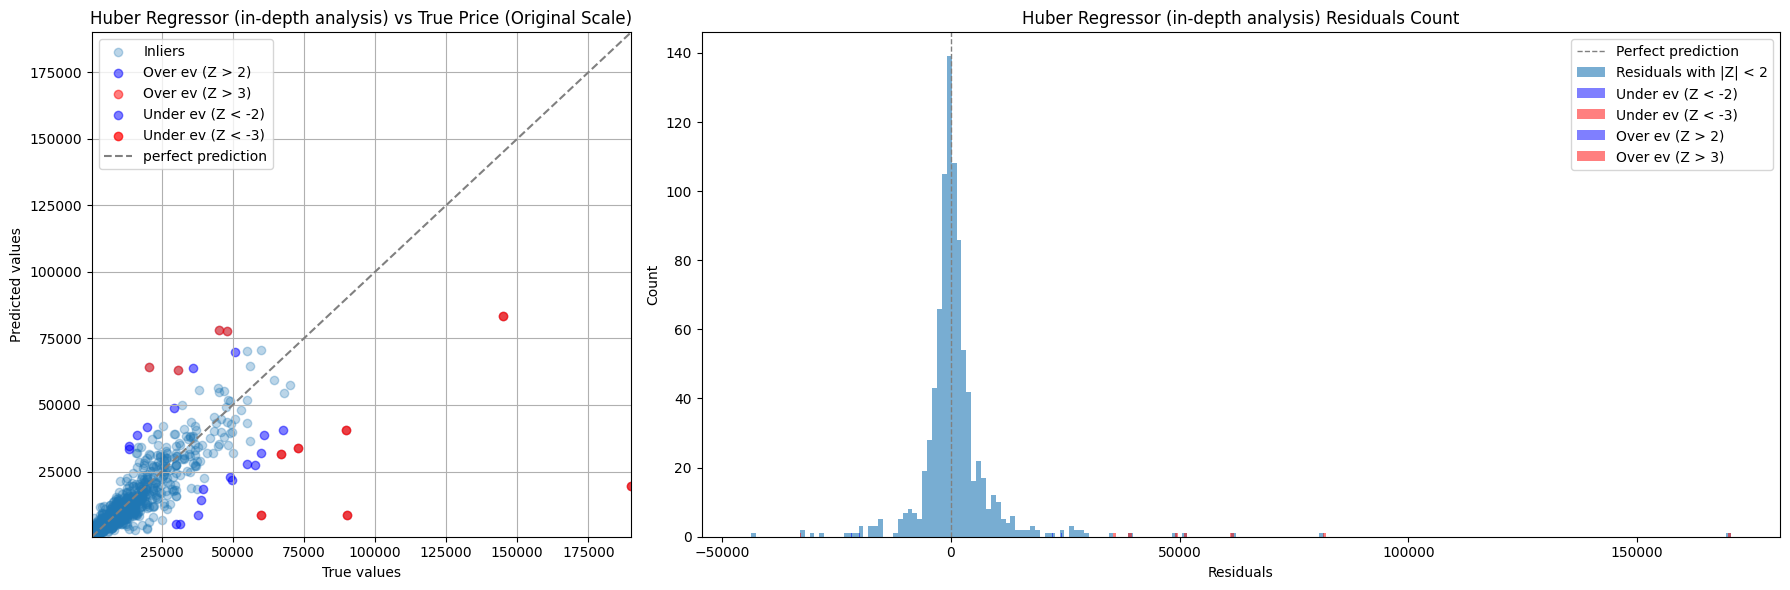

In [ ]:
model_name = 'Huber Regressor (in-depth analysis)'
print(model_name)
print(f"Best alpha: {huber_grid.best_params_['regressor__alpha']:.6g}")
print(f"Best epsilon: {huber_grid.best_params_['regressor__epsilon']:.6g}")

huber_r2 =  r2_score(y_test, huber_y_pred),
huber_mae = mean_absolute_error(10**y_test, 10**huber_y_pred)
print("Test MAE (original scale):", huber_mae)
print("Test R^2", huber_r2)

plt_res.plot_residuals(y_test, huber_y_pred, model_name)

results_df = pd.read_csv(RESULTS_FILE_PATH, index_col=[0])
if model_name in results_df.index:
  results_df = results_df.drop(model_name)

huber_results_df = pd.DataFrame({'R^2': huber_r2, 'MAE': huber_mae}, index=[model_name])
results_df = pd.concat([results_df, huber_results_df])

results_df.to_csv(RESULTS_FILE_PATH, mode='w')

>**Observation**

The Huber Regressor achieves an MAE of about 4399 and an R^2 of 0.782, clearly improving over the baseline (MAE 4700). With a relatively strong regularization parameter (alpha = 2.78) and a strict threshold for outliers (epsilon = 1.5), it provides both solid predictive accuracy and robustness against deviations in the data.

## **Quantile Regressor**

As the last of the linear models tested, we evaluate the Quantile Regressor, which is robust to outliers. The 0.5 quantile minimizes the pinball loss at the median.

In [ ]:
preprocessor = ColumnTransformer([
    ('numeric',  StandardScaler(), features_dict['numerical_features']),
    ('categorical',OneHotEncoder(handle_unknown='ignore'),features_dict['categorical_features']),
    ('binary', 'passthrough', features_dict['binary_features']),
])

qreg_pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', QuantileRegressor(quantile=0.5, solver='highs'))
])

param_grid = {
  'regressor__alpha': [0.0, 0.000001, 0.00001, 0.00001, 0.001, 0.001, 0.01]
}

cv = KFold(n_splits=5, shuffle=True, random_state=SEED)

qreg_grid = GridSearchCV(
    estimator=qreg_pipe,
    param_grid=param_grid,
    cv=cv,
    scoring=SCORING,
    n_jobs=-1,
    refit=True
)

qreg_grid.fit(X_train, y_train)
qreg_best_model = qreg_grid.best_estimator_
joblib.dump(qreg_best_model, os.path.join(BASE_PATH,"quantile.pkl"))

quartile_y_pred = qreg_best_model.predict(X_test)

Quantile Regressor (in-depth analysis)
Best alpha: 1e-05
Test MAE (original scale): 4552.060307923279
Test R^2 (0.775672254352698,)


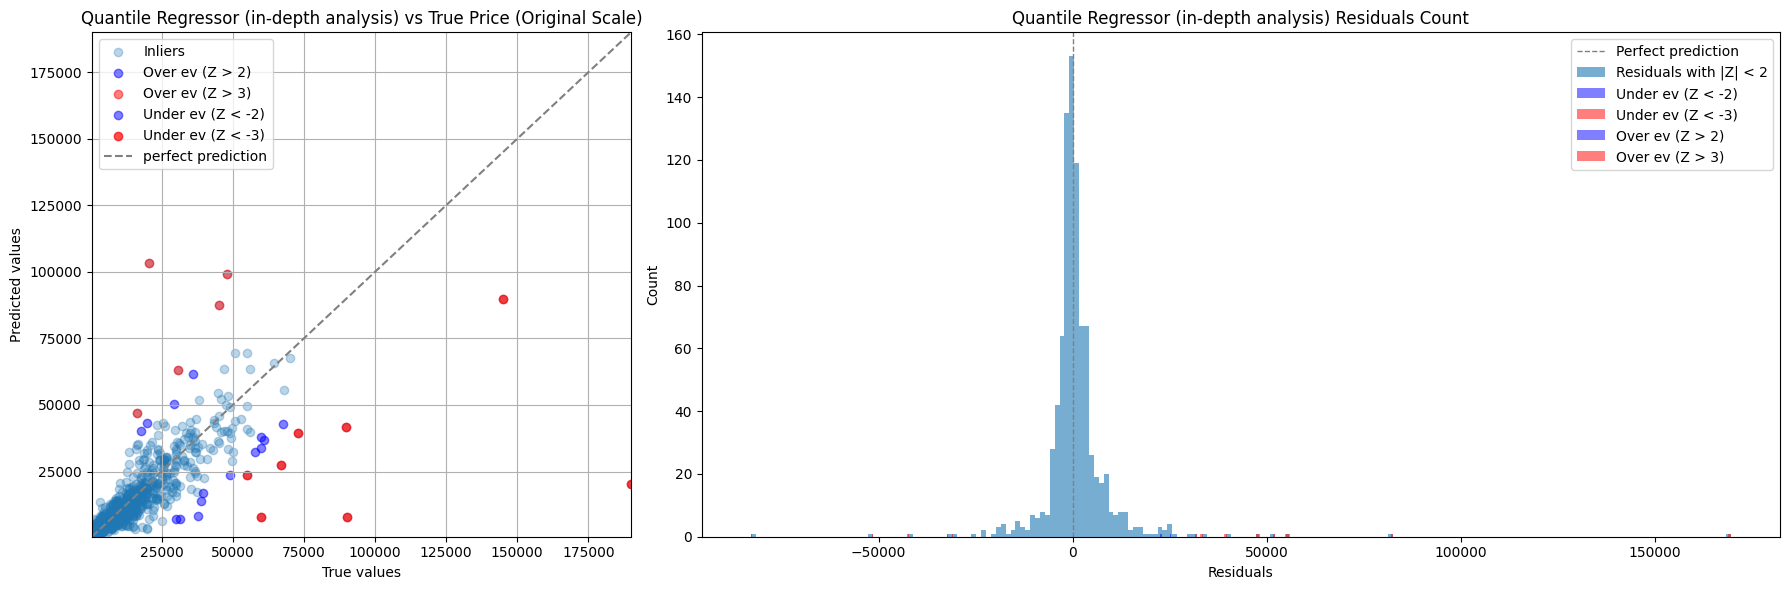

In [ ]:
model_name = 'Quantile Regressor (in-depth analysis)'
print(model_name)
print(f"Best alpha: {qreg_grid.best_params_['regressor__alpha']:.6g}")

qreg_r2 =  r2_score(y_test, quartile_y_pred),
qreg_mae = mean_absolute_error(10**y_test, 10**quartile_y_pred)
print("Test MAE (original scale):", qreg_mae)
print("Test R^2", qreg_r2)

plt_res.plot_residuals(y_test, quartile_y_pred, model_name)

results_df = pd.read_csv(RESULTS_FILE_PATH, index_col=[0])
if model_name in results_df.index:
  results_df = results_df.drop(model_name)

qreg_results_df = pd.DataFrame({'R^2': qreg_r2, 'MAE': qreg_mae}, index=[model_name])
results_df = pd.concat([results_df, qreg_results_df])

results_df.to_csv(RESULTS_FILE_PATH, mode='w')

> **Observation**

The Quantile Regressor achieves an MAE of about 4552 and an R^2 of 0.77, slightly improving over the baseline (MAE 4700). With a very small regularization parameter (alpha = 0.0001), the model applies only minimal shrinkage, emphasizing flexibility in capturing distributional characteristics of the target.

# **Decision Tree Models**

## **Decision Tree Regressor**

Decision Tree Models predict values by recursively splitting the data into regions based on feature thresholds, then assigning the average target value of each region.

Unlike a linear models, they do not assume a linear relationship between features and target, so they can capture complex nonlinear patterns. For this reason also the preprocessing steps are simplified, as the numeric values do not require a scaling preprocessing.

>**Model Training**

In [ ]:
preprocessor = ColumnTransformer([
    ('numeric', 'passthrough', features_dict['numerical_features']),
    ('categorical', OneHotEncoder(handle_unknown='ignore'),features_dict['categorical_features']),
    ('binary', 'passthrough', features_dict['binary_features']),
])

dt_pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', DecisionTreeRegressor(random_state=SEED))
])

param_grid = {
    'regressor__max_depth': [None, 3, 5, 10, 20]
}

cv = KFold(n_splits=5, shuffle=True, random_state=SEED)

dt_grid = GridSearchCV(
    estimator= dt_pipe,
    param_grid=param_grid,
    cv=cv,
    scoring=SCORING,
    n_jobs=-1,
    refit=True
)

dt_grid.fit(X_train, y_train)
dt_best_model = dt_grid.best_estimator_
joblib.dump(dt_best_model, os.path.join(BASE_PATH, "decision_tree.pkl"))

dt_y_pred = dt_best_model.predict(X_test)

>**Model Evaluation**

Decision Tree Regressor (in-depth analysis)
Best params: {'regressor__max_depth': 5}
CV best mean MAE (log scale): -0.2231
Test MAE (original scale): 6139.473355118594
Test R^2 (0.5614639693819394,)
Tree depth: 5
Tree leaves: 32


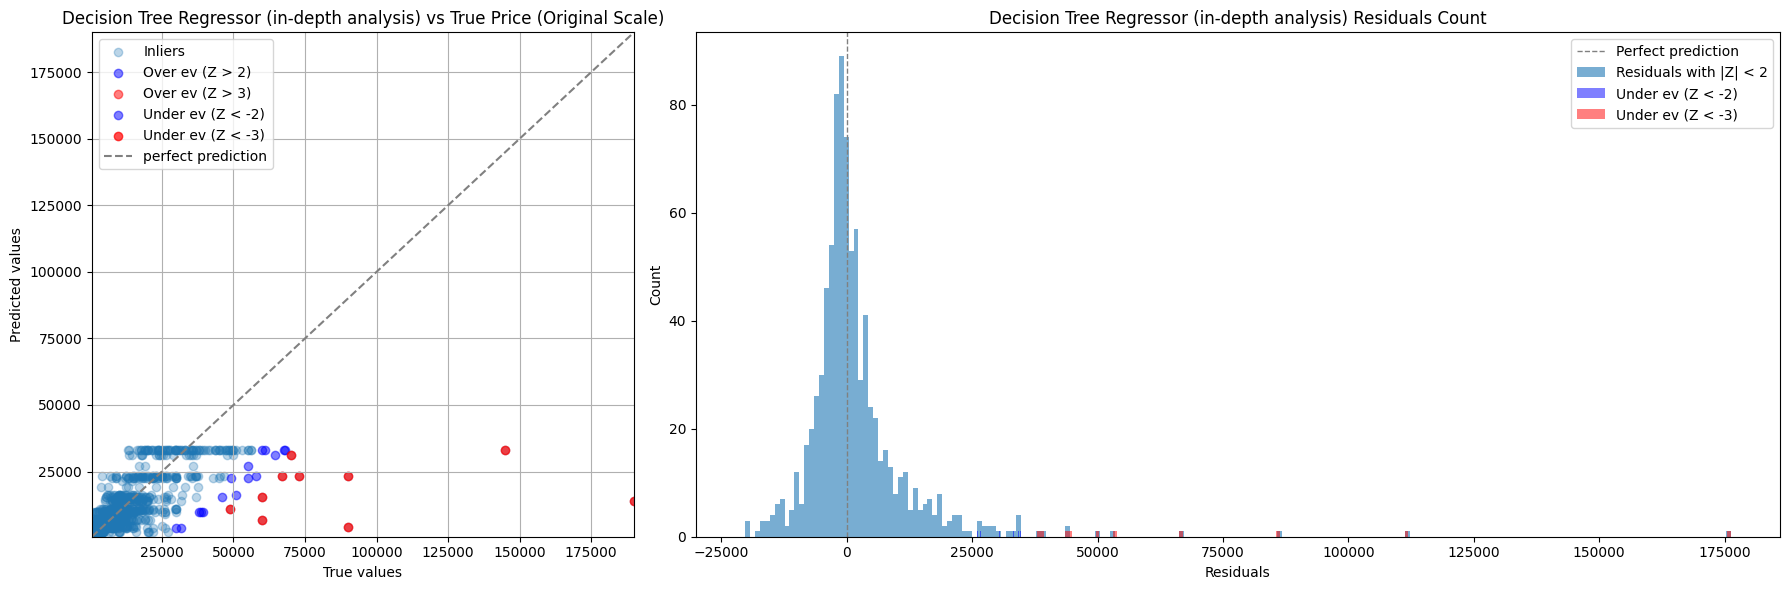

In [ ]:
model_name = 'Decision Tree Regressor (in-depth analysis)'
print(model_name)
print(f'Best params: { dt_grid.best_params_}')
print(f"CV best mean MAE (log scale): {dt_grid.best_score_:.4f}")

dt_r2 =  r2_score(y_test, dt_y_pred),
dt_mae = mean_absolute_error(10**y_test, 10**dt_y_pred)
print("Test MAE (original scale):", dt_mae)
print("Test R^2", dt_r2)

tree = dt_best_model.named_steps['regressor']
print("Tree depth:", tree.get_depth())
print("Tree leaves:", tree.get_n_leaves())

plt_res.plot_residuals(y_test, dt_y_pred, model_name)

results_df = pd.read_csv(RESULTS_FILE_PATH, index_col=[0])
if model_name in results_df.index:
  results_df = results_df.drop(model_name)

dt_results_df = pd.DataFrame({'R^2': dt_r2, 'MAE': dt_mae}, index=[model_name])
results_df = pd.concat([results_df, dt_results_df])

results_df.to_csv(RESULTS_FILE_PATH, mode='w')

> **Observation**

The Decision Tree Regressor, with a maximum depth of 5 and 32 leaves, reaches a test MAE of about 6139 and an R^2 of 0.561. This performance is notably worse than the baseline (MAE 4700), suggesting that the model struggles to generalize effectively despite the moderate tree complexity.

# **Support Vector Machines**

## **SVR - Support Vector Regressor**

We also evaluate the Support Vector Regressor (SVR), which constructs a regression function within a margin of tolerance defined by epsilon, while the parameter C controls the trade-off between model complexity and the degree to which deviations larger than epsilon are penalized.

>**Model Training**

In [ ]:
preprocessor = ColumnTransformer([
    ('numeric', StandardScaler(), features_dict['numerical_features']),
    ('categorical', OneHotEncoder(handle_unknown='ignore'),features_dict['categorical_features']),
    ('binary', StandardScaler(), features_dict['binary_features']),
])

svr_pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', SVR(kernel='rbf'))
])

param_grid = {
    'regressor__C': [1.75, 2.0, 2.5, 3.5, 5],
    'regressor__epsilon': [0.0005, 0.001, 0.01, 0.1],
}

cv = KFold(n_splits=5, shuffle=True, random_state=SEED)

svr_grid = GridSearchCV(
    estimator=svr_pipe,
    param_grid=param_grid,
    cv=cv,
    scoring=SCORING,
    n_jobs=-1,
    refit=True
)

svr_grid.fit(X_train, y_train)
svr_best_model = svr_grid.best_estimator_
joblib.dump(svr_best_model, os.path.join(BASE_PATH, "svr.pkl"))

svr_y_pred = svr_best_model.predict(X_test)

>**Model Evaluation**

Support Vector Regressor (in-depth analysis)
Best params: {'regressor__C': 1.75, 'regressor__epsilon': 0.01}
CV best mean MAE (log scale): -0.1735
Test MAE (original scale): 5121.982079733246
Test R^2 (0.7253501507235118,)


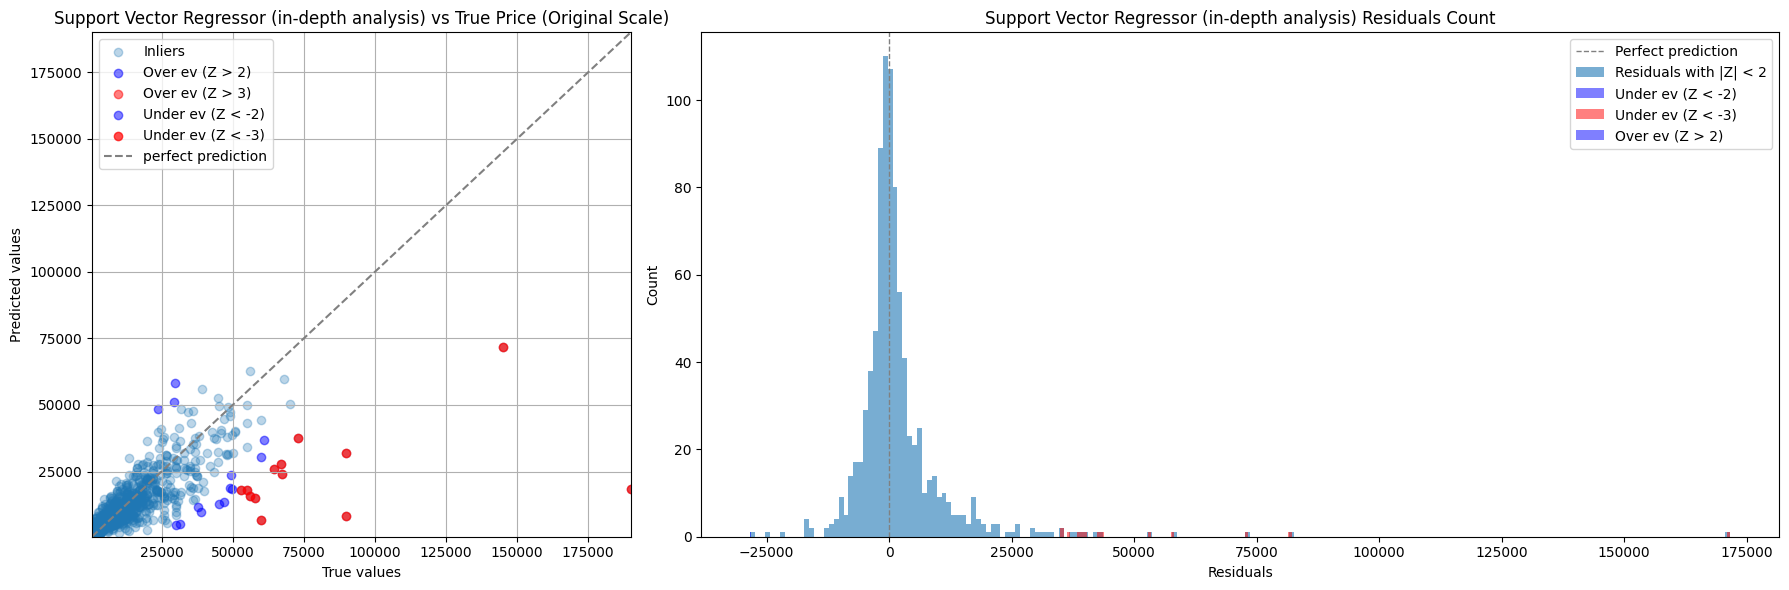

In [ ]:
model_name = 'Support Vector Regressor (in-depth analysis)'
print(model_name)
print(f'Best params: { svr_grid.best_params_}')
print(f"CV best mean MAE (log scale): {svr_grid.best_score_:.4f}")

svr_r2 =  r2_score(y_test, svr_y_pred),
svr_mae = mean_absolute_error(10**y_test, 10**svr_y_pred)
print("Test MAE (original scale):", svr_mae)
print("Test R^2", svr_r2)

plt_res.plot_residuals(y_test, svr_y_pred, model_name)

results_df = pd.read_csv(RESULTS_FILE_PATH, index_col=[0])
if model_name in results_df.index:
  results_df = results_df.drop(model_name)

svr_results_df = pd.DataFrame({'R^2': svr_r2, 'MAE': svr_mae}, index=[model_name])
results_df = pd.concat([results_df, svr_results_df])

results_df.to_csv(RESULTS_FILE_PATH, mode='w')

> **Observation**

The Support Vector Regressor, with C = 1.75 and epsilon = 0.01, achieves a test MAE of about 5122 and an R^2 of 0.725. Although worse than the baseline, the results indicate a reasonable capacity to capture non-linear patterns with a narrow error margin.

# **Ensemble Methods**

We next consider ensemble methods, which combine multiple base learners to improve predictive performance and robustness. By aggregating the outputs of several models, either through averaging (bagging), sequential refinement (boosting), or weighted combinations, ensemble techniques aim to reduce variance, mitigate bias, and capture more complex patterns in the data.

## **Random Forest Regressor**

We begin the ensemble section with the Random Forest Regressor, a bagging method that constructs multiple decision trees on bootstrapped samples and averages their predictions. This approach reduces variance and improves generalization compared to a single decision tree.

>**Model Training**

In [ ]:
preprocessor = ColumnTransformer([
    ('numeric', 'passthrough', features_dict['numerical_features']),
    ('categorical', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1),features_dict['categorical_features']),
    ('binary', 'passthrough', features_dict['binary_features']),
])

rf_pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(random_state=SEED, n_jobs=-1))
])

param_grid = {
    'regressor__n_estimators': [30, 50],
    'regressor__max_depth': [None, 10,20,200 ]
}

cv = KFold(n_splits=5, shuffle=True, random_state=SEED)

rf_grid = GridSearchCV(
    estimator=rf_pipe,
    param_grid=param_grid,
    cv=cv,
    scoring=SCORING,
    n_jobs=-1,
    refit=True
)

rf_grid.fit(X_train, y_train)
rf_best_model = rf_grid.best_estimator_
joblib.dump(rf_best_model, os.path.join(BASE_PATH, "random_forest.pkl"))

rf_y_pred = rf_best_model.predict(X_test)

>**Model Evaluation**

Random Forest Regressor (in-depth analysis)
Best params: {'regressor__max_depth': 20, 'regressor__n_estimators': 50}
Test MAE (original scale): 5264.985480047436
Test R^2 (0.667636667930809,)
Number of trees: 50
Feature importances (top 5): [0.51052867 0.11937713 0.01073451 0.00091222 0.00176662]


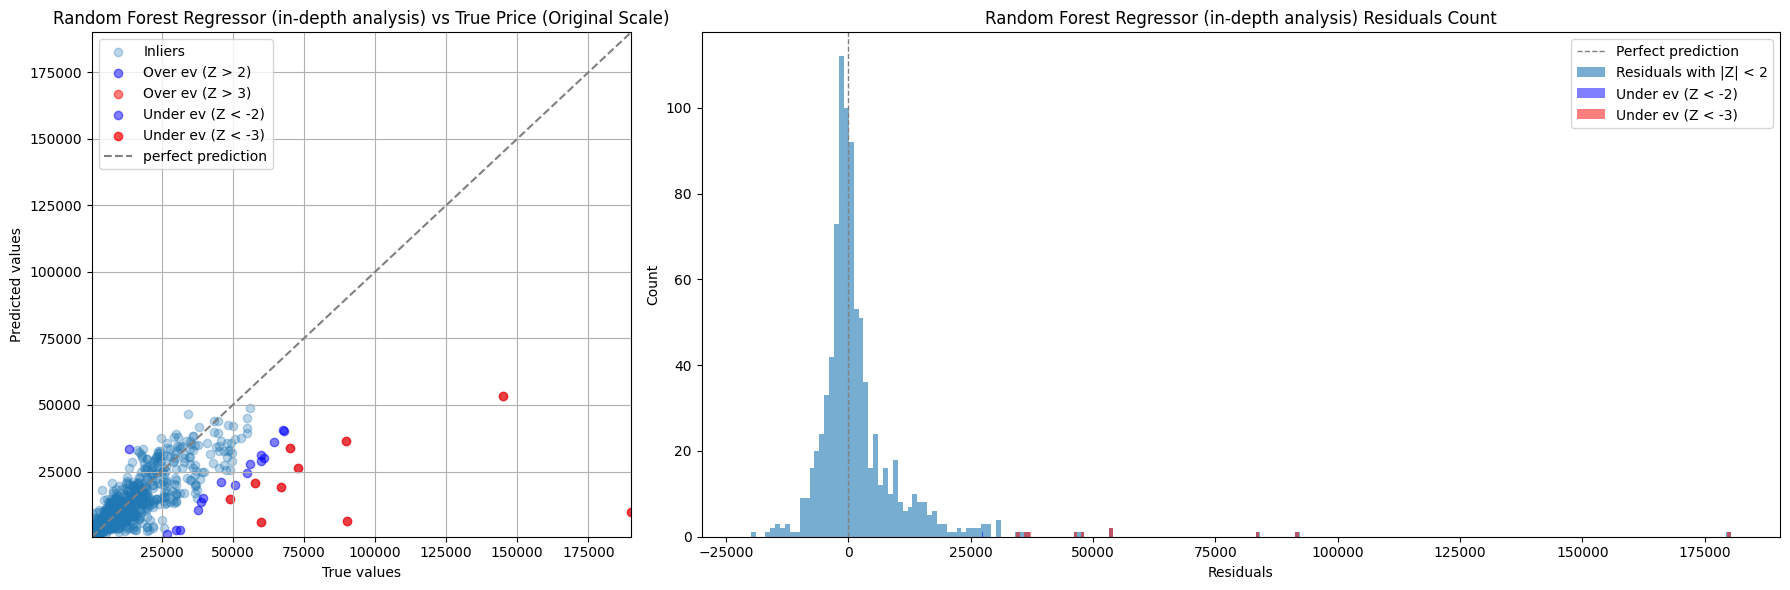

In [ ]:
model_name = 'Random Forest Regressor (in-depth analysis)'
print(model_name)
print(f'Best params: { rf_grid.best_params_}')

rf_r2 =  r2_score(y_test, rf_y_pred),
rf_mae = mean_absolute_error(10**y_test, 10**rf_y_pred)
print("Test MAE (original scale):", rf_mae)
print("Test R^2", rf_r2)

rf_model = rf_best_model.named_steps['regressor']
print("Number of trees:", len(rf_model.estimators_))
print("Feature importances (top 5):", rf_model.feature_importances_[:5])

plt_res.plot_residuals(y_test, rf_y_pred, model_name)

results_df = pd.read_csv(RESULTS_FILE_PATH, index_col=[0])
if model_name in results_df.index:
  results_df = results_df.drop(model_name)

rf_results_df = pd.DataFrame({'R^2': rf_r2, 'MAE': rf_mae}, index=[model_name])
results_df = pd.concat([results_df, rf_results_df])

results_df.to_csv(RESULTS_FILE_PATH, mode='w')

> **Observation**

The Random Forest Regressor, trained with 50 trees and a maximum depth of 20, achieves a test MAE of about 5265 and an R^2 of 0.668. It performs better than the single decision tree but remains insufficient, proving that a linear approach is more appropriate for this task.

## **BaggingRegressor with SVR**

We also test a Bagging Regressor with SVR as base estimator. Bagging builds multiple versions of the same model on different bootstrap samples of the data and then averages their predictions. This procedure reduces variance and improves stability

>**Training Model**

In [ ]:
preprocessor = ColumnTransformer([
    ('numeric', StandardScaler(), features_dict['numerical_features']),
    ('categorical', OneHotEncoder(handle_unknown='ignore'),features_dict['categorical_features']),
    ('binary', StandardScaler(), features_dict['binary_features']),
])

pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', BaggingRegressor(
        estimator=SVR(C=2.5, epsilon=0.01, kernel='rbf', gamma='scale'),
        n_estimators=25,
        bootstrap=True,
        random_state=SEED,
        n_jobs=-1
    ))
])

param_grid = {
    'regressor__n_estimators': [10, 25, 50]
}

cv = KFold(n_splits=5, shuffle=True, random_state=SEED)
grid = GridSearchCV(pipe, param_grid, cv=cv,scoring='neg_mean_absolute_error', n_jobs=-1, refit=True)

grid.fit(X_train, y_train)
bagged_svr_best_model = grid.best_estimator_
joblib.dump(bagged_svr_best_model, os.path.join(BASE_PATH, "bagged_svr.pkl"))

svr_bag_y_pred = bagged_svr_best_model.predict(X_test)

>**Evaluating Model**

Bagged SVR (in-depth analysis) {'regressor__n_estimators': 25}
Test MAE (original scale): 5116.475269480313
Test R^2 0.7252314858661325


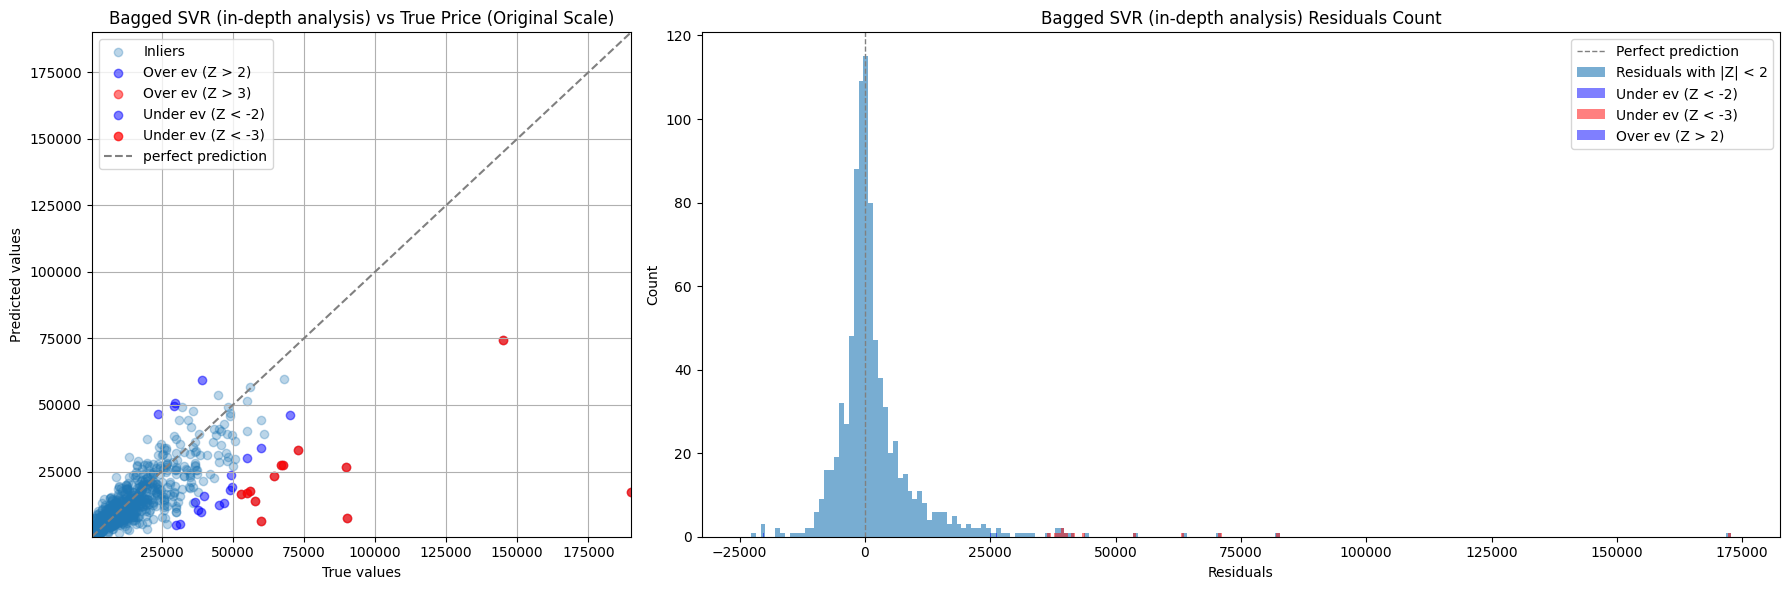

In [ ]:
model_name = 'Bagged SVR (in-depth analysis)'
print(model_name, grid.best_params_)
svr_bag_r2  = r2_score(y_test, svr_bag_y_pred)
svr_bag_mae = mean_absolute_error(10**y_test, 10**svr_bag_y_pred)
print("Test MAE (original scale):", svr_bag_mae)
print("Test R^2", svr_bag_r2)

plt_res.plot_residuals(y_test, svr_bag_y_pred, model_name)

results_df = pd.read_csv(RESULTS_FILE_PATH, index_col=0)
if model_name in results_df.index:
    results_df = results_df.drop(model_name)
add = pd.DataFrame({'R^2': [svr_bag_r2], 'MAE': [svr_bag_mae]}, index=[model_name])
results_df = pd.concat([results_df, add])
results_df.to_csv(RESULTS_FILE_PATH, mode='w')

> **Observation**

The Bagged SVR, trained with 25 base estimators, achieves a test MAE of about 5116 and an R^2S of 0.725. Its performance is nearly identical to that of the single SVR, indicating that bagging does not bring substantial improvements in this case.

## **Gradient Boosting Regressor with Huber Loss**

We evaluate Gradient Boosting with Huber loss, a stage-wise additive ensemble of shallow trees. At each iteration, a new tree is fit to the pseudo-residuals (negative gradient) of the current model (Huber) under the chosen loss (MAE), targeting remaining errors. Regularization is controlled by the number of trees and the depth, the learning rate, enabling the model to capture non-linearities and interactions with controlled variance.

>**Training Model**

In [ ]:
preprocessor = ColumnTransformer([
    ('numeric', StandardScaler(), features_dict['numerical_features']),
    ('categorical', OneHotEncoder(handle_unknown='ignore'),features_dict['categorical_features']),
    ('binary', StandardScaler(), features_dict['binary_features']),
])

gbr_pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', GradientBoostingRegressor(loss='huber', random_state=SEED))
])

gbr_grid = GridSearchCV(
    gbr_pipe,
    {
        'regressor__n_estimators': [200, 400],
        'regressor__learning_rate': [0.05, 0.1],
        'regressor__max_depth': [2, 3],
        'regressor__alpha': [0.85, 0.9]
    },
    cv=cv,
    scoring=SCORING,
    n_jobs=-1,
    refit=True
)

gbr_grid.fit(X_train, y_train)
gbr_best_model = gbr_grid.best_estimator_
joblib.dump(gbr_best_model, os.path.join(BASE_PATH, "gbr.pkl"))

gbr_y_pred = gbr_best_model.predict(X_test)

>**Evaluating Model**

Gradient Boosting with Huber Loss (in-depth analysis) {'regressor__alpha': 0.85, 'regressor__learning_rate': 0.1, 'regressor__max_depth': 3, 'regressor__n_estimators': 400}
Test MAE (original scale): 4434.748635845772
Test R^2 0.7592784417148535


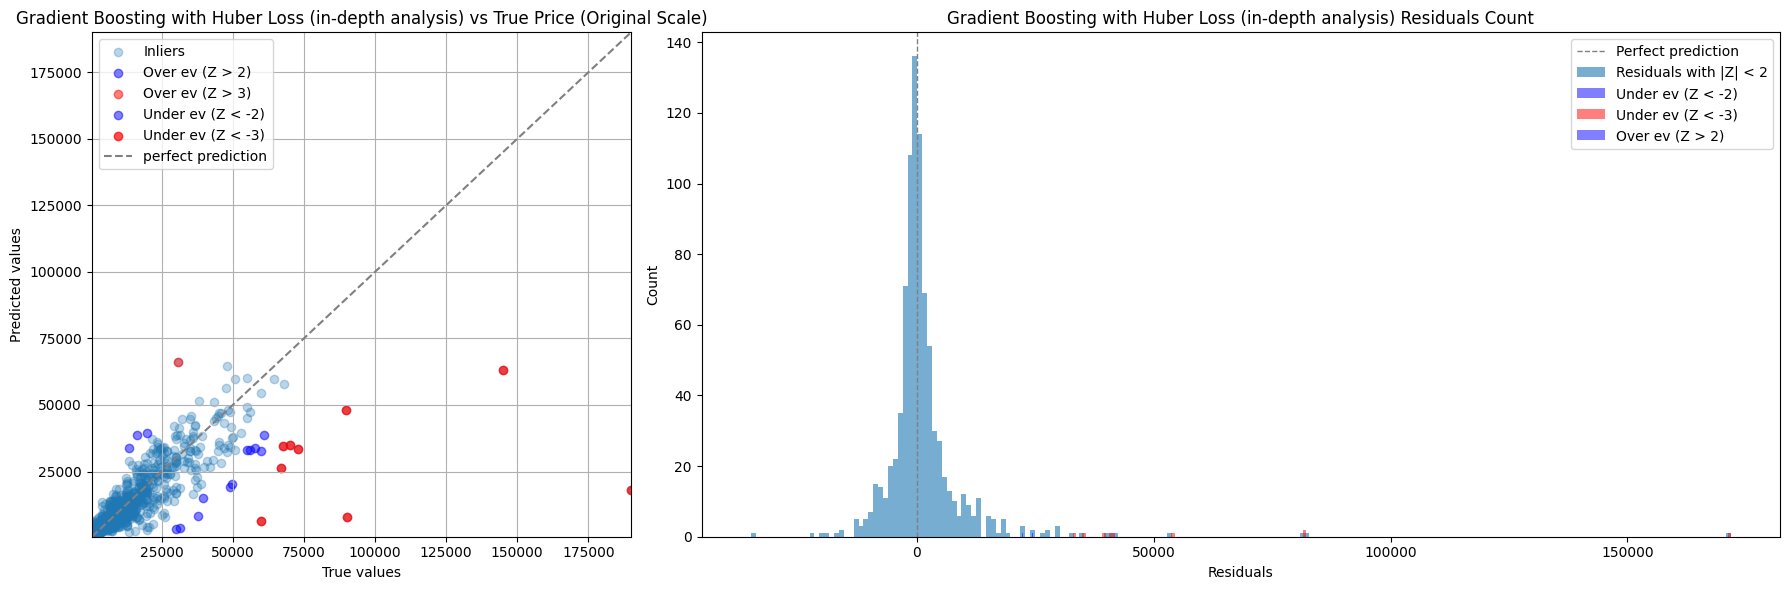

In [ ]:
model_name = 'Gradient Boosting with Huber Loss (in-depth analysis)'
print(model_name, gbr_grid.best_params_)
bgr_r2  = r2_score(y_test, gbr_y_pred)
bgr_mae = mean_absolute_error(10**y_test, 10**gbr_y_pred)
print("Test MAE (original scale):", bgr_mae)
print("Test R^2", bgr_r2)

plt_res.plot_residuals(y_test, gbr_y_pred, model_name)

results_df = pd.read_csv(RESULTS_FILE_PATH, index_col=0)
if model_name in results_df.index:
    results_df = results_df.drop(model_name)
add = pd.DataFrame({'R^2': [bgr_r2], 'MAE': [bgr_mae]}, index=[model_name])
results_df = pd.concat([results_df, add])
results_df.to_csv(RESULTS_FILE_PATH, mode='w')

> **Observation**

With n estimators = 400, max_depth = 3, learning_rate = 0.1, and alpha = 0.85, the model attains a test MAE of about 4435 and an R^2 of 0.759, improving over the baseline.

The ensemble method, with moderate shrinkage, captures non-linear structure, while the relatively strict alpha enhances robustness to outliers. It is worth noting that the ensemble methods performs similarly (slightly worse) than a simple HuberRegressor, suggesting that the robust linear model could be sufficient to match a correct variance-bias trade-off.

## **HistGradientBoosting with MAE**

We evaluate the Histogram-based Gradient Boosting Regressor with MAE (absolute-error) loss. This method bins each continuous feature into a fixed number of histogram bins and, at each boosting stage, fits a shallow decision tree to the pseudo-residuals of the MAE objective. The additive sequence of trees approximates complex, non-linear relationships, while the MAE loss targets the conditional median and reduces the influence of outliers. Regularization is governed by shrinkage (learning_rate), tree complexity (e.g., max_depth), and the number of boosting iterations (max_iter), with max_bins controlling the resolution of split candidates.

In [ ]:
preprocessor = ColumnTransformer([
    ('numeric', StandardScaler(), features_dict['numerical_features']),
    ('categorical', OneHotEncoder(handle_unknown='ignore', sparse_output=False),features_dict['categorical_features']),
    ('binary', StandardScaler(), features_dict['binary_features']),
])

hgb_pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', HistGradientBoostingRegressor(loss='absolute_error', random_state=SEED))
])

hgb_grid = GridSearchCV(
    hgb_pipe,
    {
        'regressor__max_iter': [300, 600],
        'regressor__learning_rate': [0.05, 0.1],
        'regressor__max_depth': [None, 3, 5],
        'regressor__max_bins': [255]
    },
    cv=cv,
    scoring=SCORING,
    n_jobs=-1,
    refit=True
)

hgb_grid.fit(X_train, y_train)
hgb_best_model = hgb_grid.best_estimator_
joblib.dump(hgb_best_model, os.path.join(BASE_PATH, "hgb.pkl"))

hgb_y_pred = hgb_best_model.predict(X_test)

HistGradientBoosting with MAE (in-depth analysis) {'regressor__learning_rate': 0.05, 'regressor__max_bins': 255, 'regressor__max_depth': None, 'regressor__max_iter': 600}
Test MAE (original scale): 4636.399132760008
Test R^2 0.7373526183055557


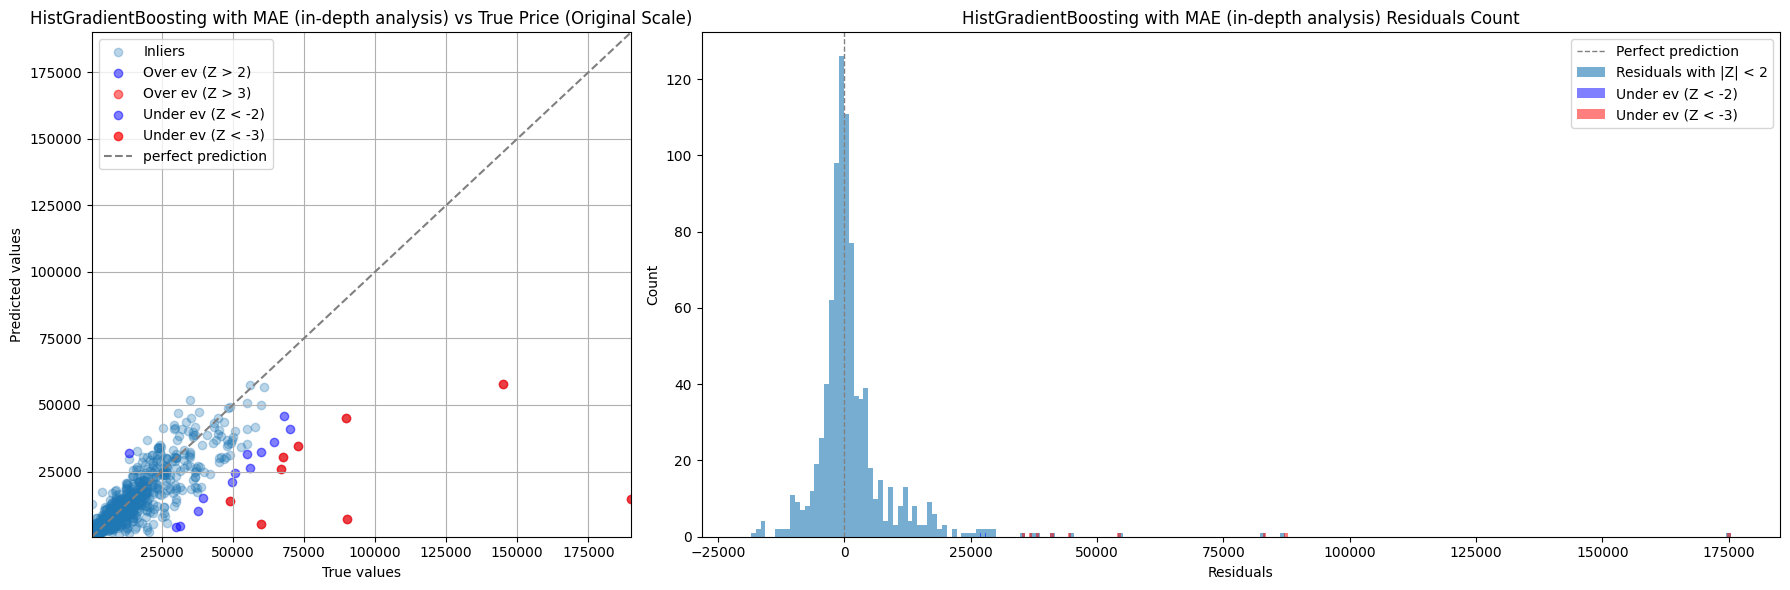

In [ ]:
model_name = 'HistGradientBoosting with MAE (in-depth analysis)'
print(model_name, hgb_grid.best_params_)
hgb_r2  = r2_score(y_test, hgb_y_pred)
hgb_mae = mean_absolute_error(10**y_test, 10**hgb_y_pred)
print("Test MAE (original scale):", hgb_mae)
print("Test R^2", hgb_r2)

plt_res.plot_residuals(y_test, hgb_y_pred, model_name)

results_df = pd.read_csv(RESULTS_FILE_PATH, index_col=0)
if model_name in results_df.index:
    results_df = results_df.drop(model_name)
add = pd.DataFrame({'R^2': [hgb_r2], 'MAE': [hgb_mae]}, index=[model_name])
results_df = pd.concat([results_df, add])
results_df.to_csv(RESULTS_FILE_PATH, mode='w')

> **Observation**

With learning_rate=0.05, max_bins=255, max_depth=None, and 600 iterations, the model attains a test MAE of about 4636 and an R^2 of 0.737, modestly improving over the LinearRegression baseline (MAE = 4700).

## **Voting Regressor**

We evaluate a Voting Regressor, a heterogeneous ensemble that aggregates the predictions of several pre-tuned base learners via averaging.

By combining models with complementary inductive biases, voting aims to reduce variance and improve robustness whenever individual errors are not perfectly correlated.

The Voting Regressor does not fit a meta-learner as its regularization derives from the base models and from the averaging itself.

In our setup, candidate panels were formed from linear robust estimators (Ridge, ElasticNet, Huber, Quantile Regression) and tree-based ensembles (Gradient Boosting with Huber loss, HistGradientBoosting with MAE).

We configured the VotingRegressor to use simple (equal-weight) averaging across the selected base models, favoring transparency and reduced model complexity over learned weights.

In [ ]:
# linear models
ridge_best_model = joblib.load(os.path.join(BASE_PATH, "ridge.pkl"))
lasso_best_model = joblib.load(os.path.join(BASE_PATH, "lasso.pkl"))
elastic_best_model = joblib.load(os.path.join(BASE_PATH, "elasticnet.pkl"))
huber_best_model = joblib.load(os.path.join(BASE_PATH, "huber.pkl"))
qreg_best_model = joblib.load(os.path.join(BASE_PATH, "quantile.pkl"))

# ensemble methods
rf_best_model = joblib.load(os.path.join(BASE_PATH, "random_forest.pkl"))
bagged_svr_best_model = joblib.load(os.path.join(BASE_PATH, "bagged_svr.pkl"))
gbr_best_model = joblib.load(os.path.join(BASE_PATH, "gbr.pkl"))
hgb_best_model = joblib.load(os.path.join(BASE_PATH, "hgb.pkl"))

In [ ]:
evaluators = [
    ('ridge', ridge_best_model),
    ('elastic', elastic_best_model),
    ('huber', huber_best_model),
    ('qreg', qreg_best_model),
    ('gbr', gbr_best_model),
    ('hgb', hgb_best_model),
]

In [ ]:
candidates = [
    [evaluators[0], evaluators[1], evaluators[2], evaluators[3]],
    [evaluators[1], evaluators[2], evaluators[4], evaluators[5]],
    [evaluators[2], evaluators[3], evaluators[4], evaluators[5]],
    [evaluators[0], evaluators[2], evaluators[4], evaluators[5]],
    [evaluators[1], evaluators[3], evaluators[4], evaluators[5]]
  ]

vr = VotingRegressor(estimators=candidates[0])

param_grid = {
    'estimators': candidates
}

cv = KFold(n_splits=5, shuffle=True, random_state=SEED)

g = GridSearchCV(
    estimator=vr,
    param_grid=param_grid,
    scoring='neg_mean_absolute_error',
    cv=cv,
    n_jobs=-1,
    refit=True,
)

g.fit(X_train, y_train)

best_voter = g.best_estimator_
joblib.dump(best_voter, os.path.join(BASE_PATH, "voting_regressor.pkl"))

vr_y_pred = best_voter.predict(X_test)

best_estimators = g.best_params_['estimators']
names = [name for name, _ in best_estimators]
print("Best candidates:", names)

Best candidates: ['huber', 'qreg', 'gbr', 'hgb']


Voting Regressor (in-depth analysis)
Test MAE (original scale): 4182.465208291871
Test R^2 0.7883756858039506


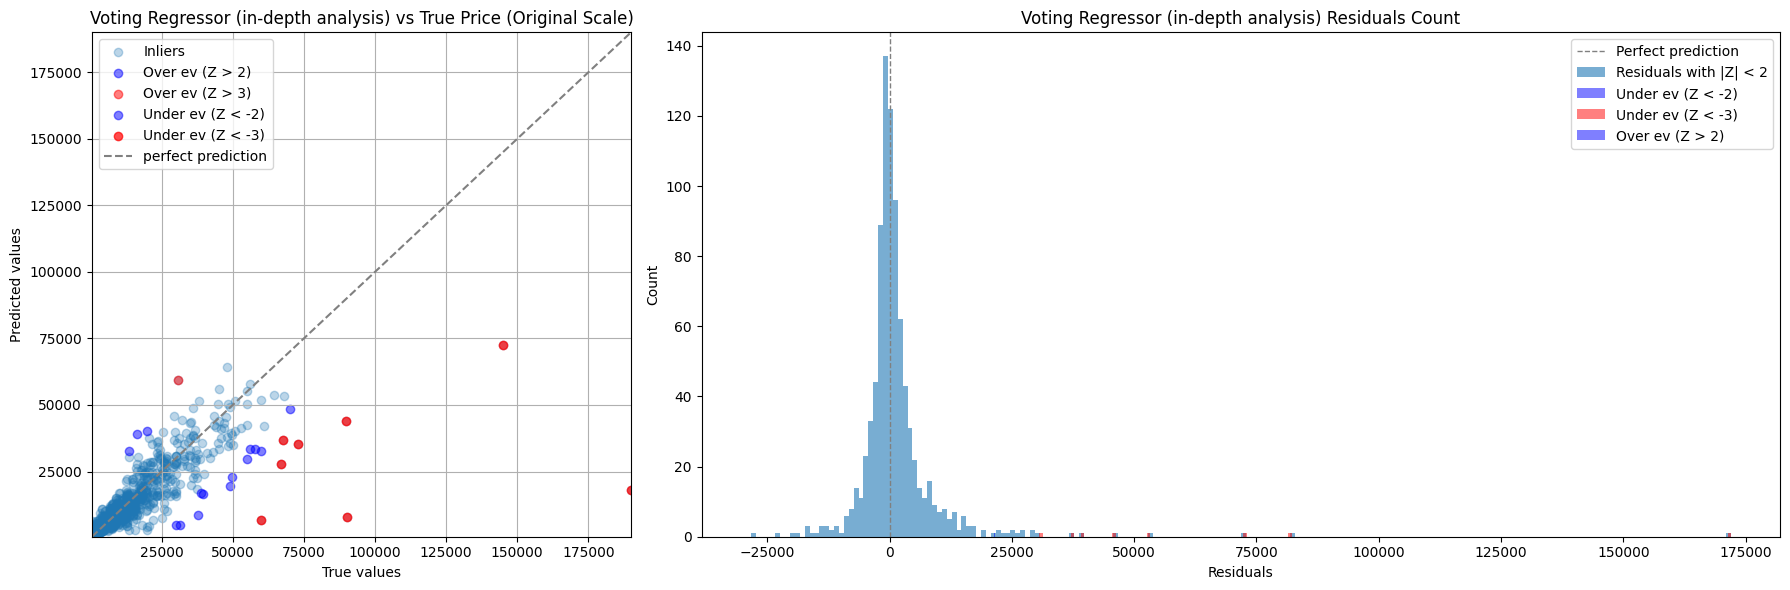

In [ ]:
model_name = 'Voting Regressor (in-depth analysis)'
print(model_name)

vr_r2  = r2_score(y_test, vr_y_pred)
vr_mae = mean_absolute_error(10**y_test, 10**vr_y_pred)
print("Test MAE (original scale):", vr_mae)
print("Test R^2", vr_r2)

plt_res.plot_residuals(y_test, vr_y_pred, model_name)

results_df = pd.read_csv(RESULTS_FILE_PATH, index_col=0)
if model_name in results_df.index:
    results_df = results_df.drop(model_name)
add = pd.DataFrame({'R^2': [vr_r2], 'MAE': [vr_mae]}, index=[model_name])
results_df = pd.concat([results_df, add])
results_df.to_csv(RESULTS_FILE_PATH, mode='w')

>**Observation**

The best panel selected by cross-validation (Huber, Quantile, GBR, HGB) combines robust linear trend capture (Huber, Quantile) with flexible nonlinear structure (GBR, HGB).

This mix balances global smooth effects with localized interactions while tempering outliers influence, which is precisely where voting tends to yield gains.

The Voting Regressor achieves a test MAE of about 4189 and an R^2 of 0.79, clearly improving over all the other models.

# **Final Best Model Selection**

## **All Model's Performance Comparison**

In [ ]:
results_df = pd.read_csv(RESULTS_FILE_PATH, index_col=[0])

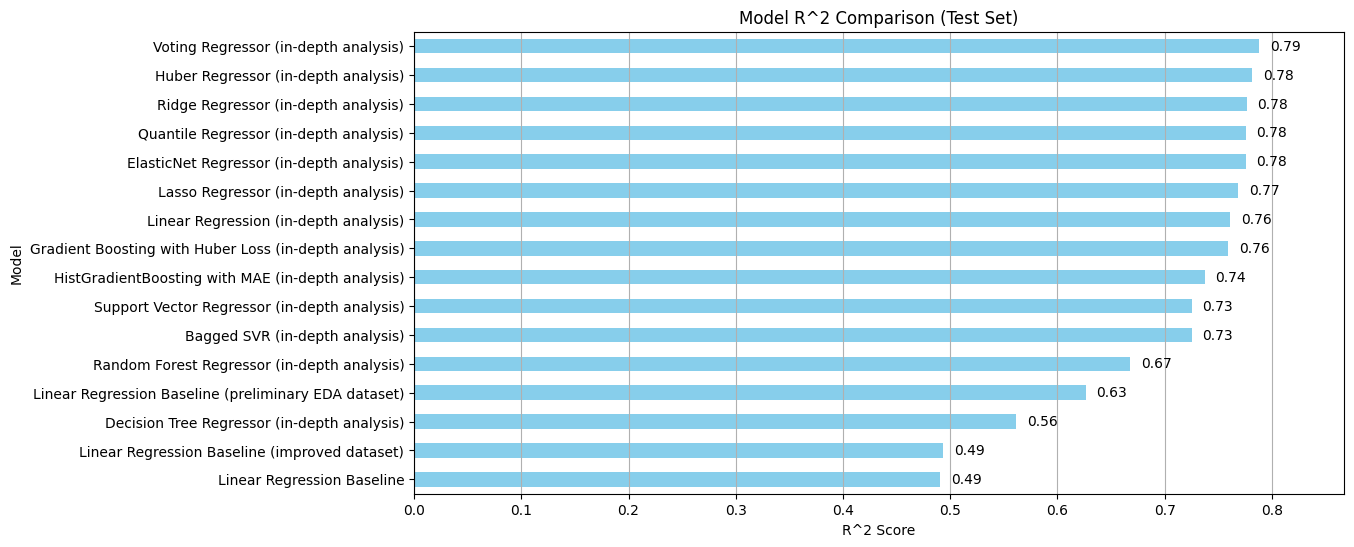

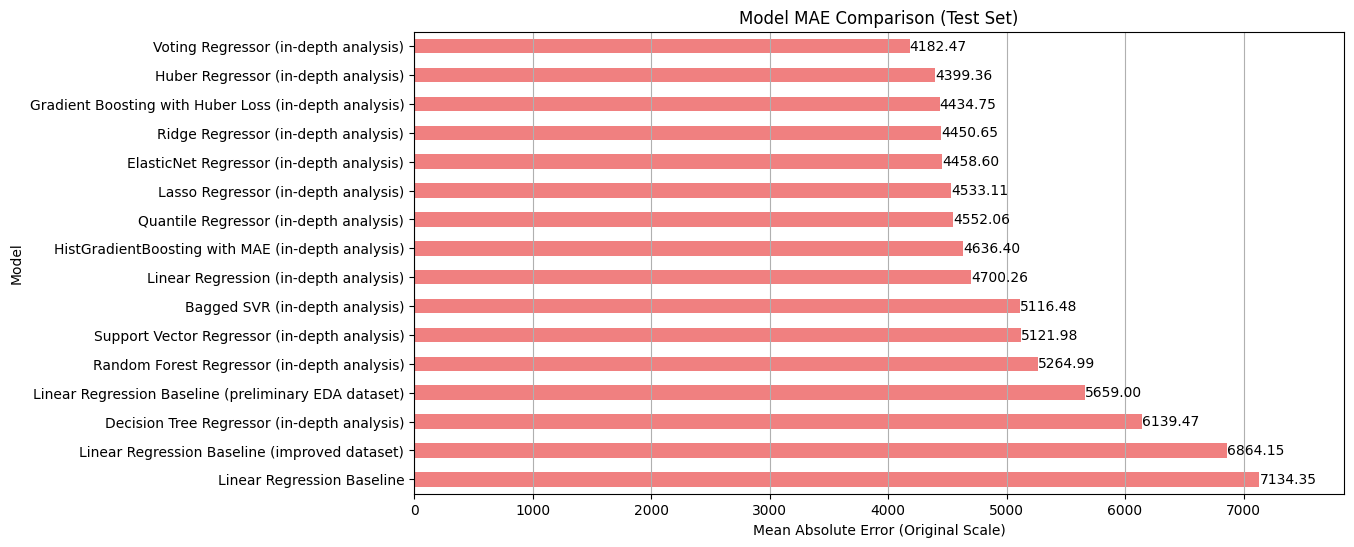

In [ ]:
# Plotting the results
fig, ax = plt.subplots(figsize=(12, 6))

# R^2 plot
r2_sorted = results_df.sort_values(by='R^2', ascending=True)['R^2']
r2_sorted.plot(kind='barh',  color='skyblue')
ax.set_title('Model R^2 Comparison (Test Set)')
ax.set_xlabel('R^2 Score')
ax.set_ylabel('Model')
ax.grid(axis='x')

# Extend x-axis for labels
ax.set_xlim(0, r2_sorted.max() * 1.1)

# Add values on bars
for i, v in enumerate(r2_sorted):
    ax.text(v + 0.01, i, f"{v:.2f}", va='center')


plt.show()

# Plotting the results
fig, ax = plt.subplots(figsize=(12, 6))
# MAE plot
mae_sorted = results_df.sort_values(by='MAE', ascending=False)['MAE']
mae_sorted.plot(kind='barh', color='lightcoral')
ax.set_title('Model MAE Comparison (Test Set)')
ax.set_xlabel('Mean Absolute Error (Original Scale)')
ax.set_ylabel('Model')
ax.grid(axis='x')

# Extend x-axis for labels
ax.set_xlim(0, mae_sorted.max() * 1.1)

# Add values on bars
for i, v in enumerate(mae_sorted):
    ax.text(v + 0.01, i, f"{v:.2f}", va='center')

plt.show()

>**Conclusion**

Across all candidates, the Voting Regressor, an equal-weight average of Huber, Quantile, Gradient Boosting (Huber), and HistGradientBoosting (MAE), delivers the strongest accuracy with MAE of 4189 and R^2 of 0.787, a 10.86% MAE reduction versus the Linear Regression baseline trained on the same dataset (4700).

The best single model, the HuberRegressor, attains MAE of 4399 and R^2 of 0.782 (a 6.40% reduction versus the baseline).
Thus, voting yields a further 4.77% MAE improvement relative to Huber by combining complementary approaches (robust linear trend and flexible tree ensembles).

Other models provide smaller gain. Ridge, ElasticNet and Gradient Boosting with Huber loss reduce MAE compared to the Linear Regression baseline by nearly 5%; Quantile and HGB by approximately 2%, whereas tree-only baselines and SVR variants underperform on MAE.

In light of these results, we emphasize that a simpler model (HuberRegressor) already achieves very good and interpretable performance, fast to train, easy to monitor, and robust to mild outliers.

Nevertheless, under the present evaluation, the most accurate choice is the Voting Regressor, which we recommend as the primary deployment model, with Huber maintained as a strong shadow benchmark for monitoring and periodic re-assessment.
